# Chapter-15 Data Transformations
This notebook contains the sample source code explained in the book *Hands-On Julia Programming, Sambit Kumar Dash, 2021, bpb Publications. All Rights Reserved*.

If you are using Linux or Mac OS X platform to launch `IJulia.notebook()`, make sure you have set the environment variable `JULIA_COPY_STACKS=1` in the shell. This step is not required for the Windows platforms. 

In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating environment at `~/work/books/HOJP/Chapter-15/Project.toml`


## Introduction

## FileIO

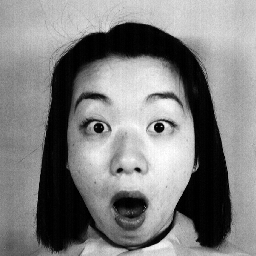

In [2]:
using FileIO
using ImageShow

tiff = joinpath(dirname(pathof(FileIO)), "..", "test", "files", "magic2.tiff")
image = load(tiff)

In [3]:
save("magic2.jpg", image)

## Text Data

### Delimited Files
Please refer to Chapter-9 for an example of accessing data in a CSV file. 

### XML Files
Julia has three packages for accessing data from XML files. `LightXML` and `EzXML` are `libxml2` based and are DOM parsers. `LibExpat` depends on `libexpat`, a stream based XML library. 

In [4]:
# Sample taken from https://github.com/JuliaIO/LightXML.jl 

using LightXML
xdoc = parse_file("books.xml")

xroot = root(xdoc)
println("Root Name: ", name(xroot))

for c in child_nodes(xroot)
    println("Node type:", nodetype(c))
    if is_elementnode(c)
        e = XMLElement(c)
        println("Element Name: ", name(e))
    end
end

#=
The memory allocated by libxml2 needs to be cleaned by calling free explicitly.
=#
LightXML.free(xdoc);

Root Name: bookstore
Node type:3
Node type:1
Element Name: book
Node type:3
Node type:1
Element Name: book
Node type:3


However, if you will like to search with XPath or validating the XML with a DTD you can use `EzXML`. Needless to say you can traverse the tree in `EzXML` as well. 

In [5]:
using EzXML

doc = readxml("books.xml")

validate(doc)

for author in nodecontent.(findall("//author/text()", doc))
    println(author)
end

Giada De Laurentiis
J K. Rowling


`books.xml` is being read with `LibExpat` a stream based parser. 

In [6]:
using LibExpat
esm = xp_parse(read("books.xml", String))

<bookstore> 
  <book tag="first" category="COOKING">
    <title lang="en">Everyday Italian</title>
    <author>Giada De Laurentiis</author>
    <year>2005</year>
    <price>30.00</price>
  </book>
  <book category="CHILDREN">
    <title lang="en">Harry Potter</title>
    <author>J K. Rowling</author>
    <year>2005</year>
    <price>29.99</price>
  </book>
</bookstore>

In [7]:
authors = LibExpat.find(esm, "/bookstore/book/author")

2-element Vector{ETree}:
 <author>Giada De Laurentiis</author>
 <author>J K. Rowling</author>

### HTML Files

`Gumbo` package based on the Google Gumbo library can be used to read and manipulate HTML documentations with ease. 

In [8]:
using Gumbo
doc = Gumbo.parsehtml("<h1> Hello, world! </h1>")


HTML Document:
<!DOCTYPE >
HTMLElement{:HTML}:<HTML>
  <head></head>
  <body>
    <h1>
      Hello, world!
    </h1>
  </body>
</HTML>



In [9]:
using AbstractTrees
for elem in PreOrderDFS(doc.root) println(hasmethod(tag, (typeof(elem),)) ? tag(elem) : elem) end

HTML
head
body
h1
 Hello, world! 


Elements can be accessed with indexing as well. 

In [10]:
doc.root[2][1][1]

HTML Text: ` Hello, world! `

### PDF Files

`PDFIO` can be used to extract data from PDF files. 

In [11]:
using PDFIO
"""
```
    getPDFText(src, out) -> Dict 
```
- src - Input PDF file path from where text is to be extracted
- out - Output TXT file path where the output will be written
return - A dictionary containing metadata of the document
"""
function getPDFText(src, out)
    doc = pdDocOpen(src)
    docinfo = pdDocGetInfo(doc) 
    open(out, "w") do io
        npage = pdDocGetPageCount(doc)
        for i=1:npage 
            page = pdDocGetPage(doc, i)
            pdPageExtractText(io, page)
        end
    end
    pdDocClose(doc)
    return docinfo
end


getPDFText

In [12]:
getPDFText("sample-google-doc.pdf", "sample-google-doc.txt")

Dict{String, Union{CDDate, String, CosObject}} with 1 entry:
  "Producer" => "Skia/PDF m79"

In [13]:
read("sample-google-doc.txt", String)

"        Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut \n        labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco \n        laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in \n        voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non \n        proident, sunt in culpa qui officia deserunt mollit anim id est laborum. "

### Microsoft Office Documents 

`Taro` can be used to extract text from Microsoft Word documents and reading tabular data from the excel files. 

In [14]:
using Taro
Taro.init()

In [15]:
docxfile=joinpath(dirname(pathof(Taro)), "..", "test", "WhyJulia.docx");
meta, text = Taro.extract(docxfile);
println(meta["meta:author"])
println(text[1:54])

Avik Sengupta
Why we created Julia

In short, because we are greedy.


Jul 22, 2021 6:59:54 PM org.apache.tika.config.InitializableProblemHandler$3 handleInitializableProblem
See https://pdfbox.apache.org/2.0/dependencies.html#jai-image-io
for optional dependencies.

Jul 22, 2021 6:59:54 PM org.apache.tika.config.InitializableProblemHandler$3 handleInitializableProblem
you've excluded the TesseractOCRParser from the default parser.
Tesseract may dramatically slow down content extraction (TIKA-2359).
As of Tika 1.15 (and prior versions), Tesseract is automatically called.
In future versions of Tika, users may need to turn the TesseractOCRParser on via TikaConfig.
Jul 22, 2021 6:59:54 PM org.apache.tika.config.InitializableProblemHandler$3 handleInitializableProblem
Please provide the jar on your classpath to parse sqlite files.
See tika-parsers/pom.xml for the correct version.


You can read tabular data from an Excel document as well. 

In [16]:
using DataFrames

xlsxfile="df-test.xlsx"
xlsxpath=joinpath(dirname(pathof(Taro)), "..", "test", xlsxfile)
cp(xlsxpath, joinpath(pwd(), xlsxfile), force=true)
chmod(xlsxfile, 0o644)
df = DataFrame( Taro.readxl(xlsxfile, "Sheet1", "B2:F8"))


,H1,H2,H3,H4,H5
,Any,Any,Any,Any,Any
1,a,1.0,1.0,1.0,a a
2,b,2.0,2.0,1.0,b b
3,c,missing,3.0,0.0,c c
4,d,4.0,missing,missing,d d
5,e,5.0,5.0,1.0,e e
6,missing,6.0,6.0,1.0,


You can use `XLSX.jl` to read MS Excel files as well.  

In [17]:
using XLSX

In [18]:
xlsx = XLSX.readxlsx("df-test.xlsx")

XLSXFile("df-test.xlsx") containing 1 Worksheet
            sheetname size          range        
-------------------------------------------------
               Sheet1 9x5           B2:F10       


In [19]:
sheet = xlsx["Sheet1"]

9×5 XLSX.Worksheet: ["Sheet1"](B2:F10)

In [20]:
sheet["B2"]

"H1"

In [21]:
sheet["C4:E9"]

6×3 Matrix{Any}:
 2         2         1.0
  missing  3         0.0
 4          missing   missing
 5         5         1.0
 6         6         1.0
 7         7         1.0

In [22]:
DataFrame(XLSX.readtable("df-test.xlsx", "Sheet1")...)

,H1,H2,H3,H4,H5
,Any,Any,Any,Any,Any
1,a,1,1,1.0,a a
2,b,2,2,1.0,b b
3,c,missing,3,0.0,c c
4,d,4,missing,missing,d d
5,e,5,5,1.0,e e
6,missing,6,6,1.0,
7,g,7,7,1.0,g g
8,h,8,8,1.0,h h


## Image Data

A fixed point representation of a gray image stored as byte array and 8-bits per pixel of data. 

In [23]:
typeof(image)

Matrix{ColorTypes.Gray{FixedPointNumbers.N0f8}} (alias for Array{ColorTypes.Gray{FixedPointNumbers.Normed{UInt8, 8}}, 2})

## Tabular Data

In [24]:
using Tables

rows = Tables.rows(df)

,H1,H2,H3,H4,H5
,Any,Any,Any,Any,Any
1,a,1.0,1.0,1.0,a a
2,b,2.0,2.0,1.0,b b
3,c,missing,3.0,0.0,c c
4,d,4.0,missing,missing,d d
5,e,5.0,5.0,1.0,e e
6,missing,6.0,6.0,1.0,


In [25]:
cols = Tables.columns(df)
cols[:H1]

6-element Vector{Any}:
 "a"
 "b"
 "c"
 "d"
 "e"
 missing

In [26]:
Tables.columnnames(df)

5-element Vector{Symbol}:
 :H1
 :H2
 :H3
 :H4
 :H5

Although `Matrix` is technically not a Table, one can create a `DataFrame` from it and create a table from it.  

In [27]:
rows = Tables.rows(DataFrame([ 1 2 3; 4 5 6; 7 8 9]))

,x1,x2,x3
,Int64,Int64,Int64
1,1,2,3
2,4,5,6
3,7,8,9


In [28]:
Tables.schema(df)

Tables.Schema:
 :H1  Any
 :H2  Any
 :H3  Any
 :H4  Any
 :H5  Any

## Data Visualization

We shall use the `Plots` package to visualize data.  

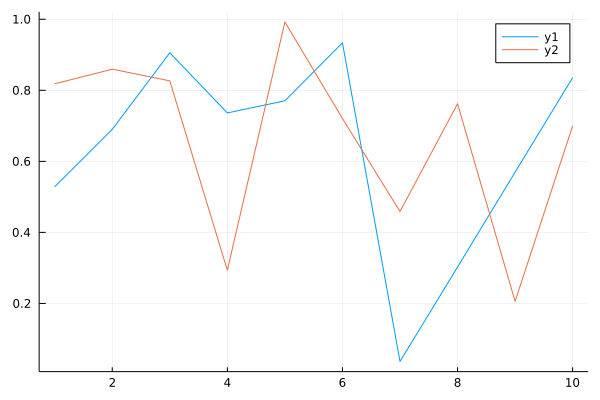

In [29]:
using Plots
x = 1:10; y = rand(10); z = rand(10) 
plot(x, [y, z])

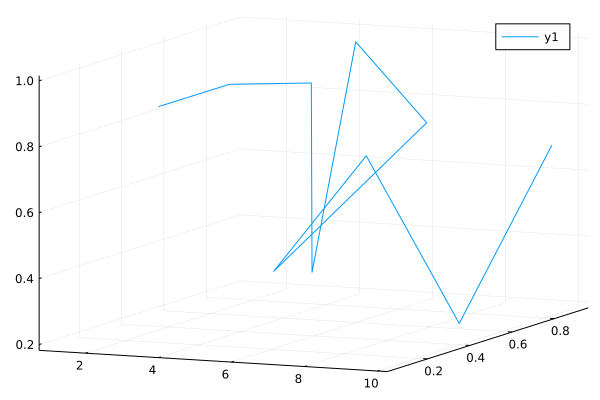

In [30]:
plot(x, y, z)

In [31]:
backend()

Plots.GRBackend()

GR is a simple yet fast plotting backend. Julia supports many other backends as well. 

In [32]:
backends()

10-element Vector{Symbol}:
 :pyplot
 :unicodeplots
 :plotly
 :plotlyjs
 :gr
 :pgfplots
 :pgfplotsx
 :inspectdr
 :hdf5
 :gaston

## 15.7 Conclusion

## Exercises